In [1]:
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
import equinox as eqx

---

# Spectrums

### Array and Polynomial

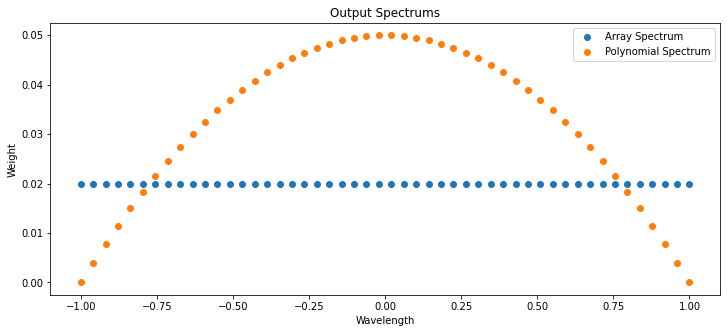

In [2]:
from spectrums import ArraySpectrum, PolynomialSpectrum

nwavels = 50
wavels = np.linspace(-1, 1, nwavels) 
# Yes wavelengths cant be negative but it is easier
# to show the polynomail acting correctly like this
coeffs = np.array([0.05, 0, -0.05])

arrspec  = ArraySpectrum(wavels, np.ones(nwavels)).normalise()
polyspec = PolynomialSpectrum(wavels, coeffs)

# Basic testing
spec1 = arrspec.get_spectrum()
spec2 = polyspec.get_spectrum()

# Basic tests
assert np.allclose(arrspec.get_wavelengths(),  spec1[0])
assert np.allclose(arrspec.get_weights(),      spec1[1])

assert np.allclose(polyspec.get_wavelengths(), spec2[0])
assert np.allclose(polyspec.get_weights(),     spec2[1])

plt.figure(figsize=(12, 5))
plt.title("Output Spectrums")
plt.scatter(spec1[0], spec1[1], label="Array Spectrum")
plt.scatter(spec2[0], spec2[1], label="Polynomial Spectrum")
plt.xlabel("Wavelength")
plt.ylabel("Weight")
plt.legend()
plt.show()

## Combined

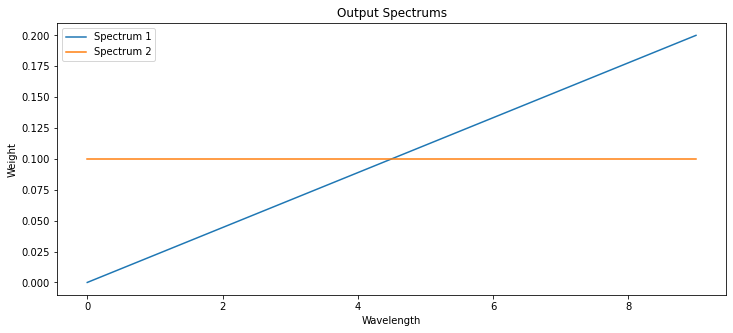

In [3]:
from spectrums import CombinedSpectrum

spec = CombinedSpectrum([np.arange(10), np.arange(10)], [np.arange(10), np.ones(10)])
spec = spec.normalise()
spec_out = spec.get_spectrum()

plt.figure(figsize=(12, 5))
plt.title("Output Spectrums")
for i in range(spec_out.shape[1]):
    plt.plot(spec_out[0, i], spec_out[1, i], label='Spectrum {}'.format(i+1))
plt.xlabel("Wavelength")
plt.ylabel("Weight")
plt.legend()
plt.show()

---

# Sources

## Point

In [4]:
from sources import Source, PointSource, ResolvedSource, GaussianSource, ExtendedSource, BinarySource

# Point source Testing
nwavels = 25
wavelengths = np.linspace(4e-7, 6e-7, nwavels)
spectrum_in = ArraySpectrum(wavelengths)

position = np.array([0, 0]) # On axis
flux = np.asarray(1e6)

point = PointSource(position, flux, spectrum_in)

assert np.allclose(point.get_position(), position)
assert np.allclose(point.get_flux(), flux)
assert np.allclose(point.get_spectrum()[0], wavelengths)
assert np.allclose(point.get_spectrum()[1].sum(), 1)
assert point.is_resolved() is False

## Binary

In [5]:
# Testing
nwavels = 10
wavels = np.linspace(4e-7, 5e-7, nwavels)
wavelengths = [wavels, wavels]
weights = [np.ones(nwavels), np.linspace(0.5, 1, nwavels)]
spectrum = CombinedSpectrum(wavelengths, weights)

position = np.zeros(2)
separation = 1
field_angle = 0

mean_flux = 3*np.ones(1)
flux_ratio = 2 * np.ones(1)
resolved = np.array([False, False])

source = BinarySource(position, mean_flux, separation, field_angle, flux_ratio, spectrum, resolved)
assert np.allclose(source.is_resolved(), resolved)

---

# Scene

In [6]:
from base import Scene

# Combined Spectrum for Binary
nwavels = 10
wavels = np.linspace(4e-7, 5e-7, nwavels)
wavelengths = [wavels, wavels]
weights = [np.ones(nwavels), np.linspace(0.5, 1, nwavels)]
combined_spectrum = CombinedSpectrum(wavelengths, weights)

# Binary Source
position = np.zeros(2)
separation = 1e-5
field_angle = 0

flux = 1
flux_ratio = 2

resolved = [False, False]
binary_source = BinarySource(position, mean_flux, separation, field_angle, flux, combined_spectrum, resolved, name="Binary")

# Spectrum for Point Source
point_spectrum = ArraySpectrum(wavelengths[0])
point_position = np.array([0, 1e-5]) # On axis
point_source = PointSource(point_position, flux, point_spectrum, name="Point")

# Combine into Scene
scene = Scene([point_source, binary_source])

In [7]:
modelling_dict = scene.decompose()

In [8]:
wls = modelling_dict['wavelengths']
print(wls.shape)
print(wls)

(3, 10)
[[4.0000000e-07 4.1111113e-07 4.2222223e-07 4.3333333e-07 4.4444445e-07
  4.5555555e-07 4.6666665e-07 4.7777780e-07 4.8888887e-07 5.0000000e-07]
 [4.0000000e-07 4.1111113e-07 4.2222223e-07 4.3333333e-07 4.4444445e-07
  4.5555555e-07 4.6666665e-07 4.7777780e-07 4.8888887e-07 5.0000000e-07]
 [4.0000000e-07 4.1111113e-07 4.2222223e-07 4.3333333e-07 4.4444445e-07
  4.5555555e-07 4.6666665e-07 4.7777780e-07 4.8888887e-07 5.0000000e-07]]


In [9]:
wgs = modelling_dict['weights']
print(wgs.shape)
print(wgs)
print(wgs.sum(1))

(3, 10)
[[0.09999999 0.09999999 0.09999999 0.09999999 0.09999999 0.09999999
  0.09999999 0.09999999 0.09999999 0.09999999]
 [0.3        0.3        0.3        0.3        0.3        0.3
  0.3        0.3        0.3        0.3       ]
 [0.20000002 0.22222222 0.24444443 0.26666665 0.28888887 0.31111112
  0.33333337 0.35555553 0.37777779 0.40000004]]
[0.99999976 2.9999998  3.0000002 ]


In [10]:
pos = modelling_dict['positions']
print(pos.shape)
print(pos)

(3, 10, 2)
[[[ 0.e+00  1.e-05]
  [ 0.e+00  1.e-05]
  [ 0.e+00  1.e-05]
  [ 0.e+00  1.e-05]
  [ 0.e+00  1.e-05]
  [ 0.e+00  1.e-05]
  [ 0.e+00  1.e-05]
  [ 0.e+00  1.e-05]
  [ 0.e+00  1.e-05]
  [ 0.e+00  1.e-05]]

 [[ 5.e-06  0.e+00]
  [ 5.e-06  0.e+00]
  [ 5.e-06  0.e+00]
  [ 5.e-06  0.e+00]
  [ 5.e-06  0.e+00]
  [ 5.e-06  0.e+00]
  [ 5.e-06  0.e+00]
  [ 5.e-06  0.e+00]
  [ 5.e-06  0.e+00]
  [ 5.e-06  0.e+00]]

 [[-5.e-06  0.e+00]
  [-5.e-06  0.e+00]
  [-5.e-06  0.e+00]
  [-5.e-06  0.e+00]
  [-5.e-06  0.e+00]
  [-5.e-06  0.e+00]
  [-5.e-06  0.e+00]
  [-5.e-06  0.e+00]
  [-5.e-06  0.e+00]
  [-5.e-06  0.e+00]]]


In [11]:
res = modelling_dict['resolved']
print(res.shape)
print(res)

(3, 10)
[[False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]]


In [12]:
# Kinda broken RN
key = modelling_dict['source_key']
print(key)

['Point', 'Binary']


---

# Optics

In [13]:
import dLux as dl
layers = [dl.CreateWavefront(256, 1),
          dl.TiltWavefront(),
          dl.CompoundAperture([0.5]),
          dl.NormaliseWavefront(),
          dl.AngularMFT(1e-7, 256)]

from base import Optics
osys = Optics(layers)

In [14]:
vector_prop = jax.vmap(osys.propagate_mono, in_axes=(0, 0))
source_prop = jax.vmap(vector_prop, in_axes=(0, 0))
modelling_dict = scene.decompose()

wavels = modelling_dict['wavelengths']
offsets = modelling_dict['positions']
weights = np.expand_dims(modelling_dict['weights'], (-1, -2))

out = weights * source_prop(wavels, offsets)
psfs = out.sum(1)
image = psfs.sum(0)

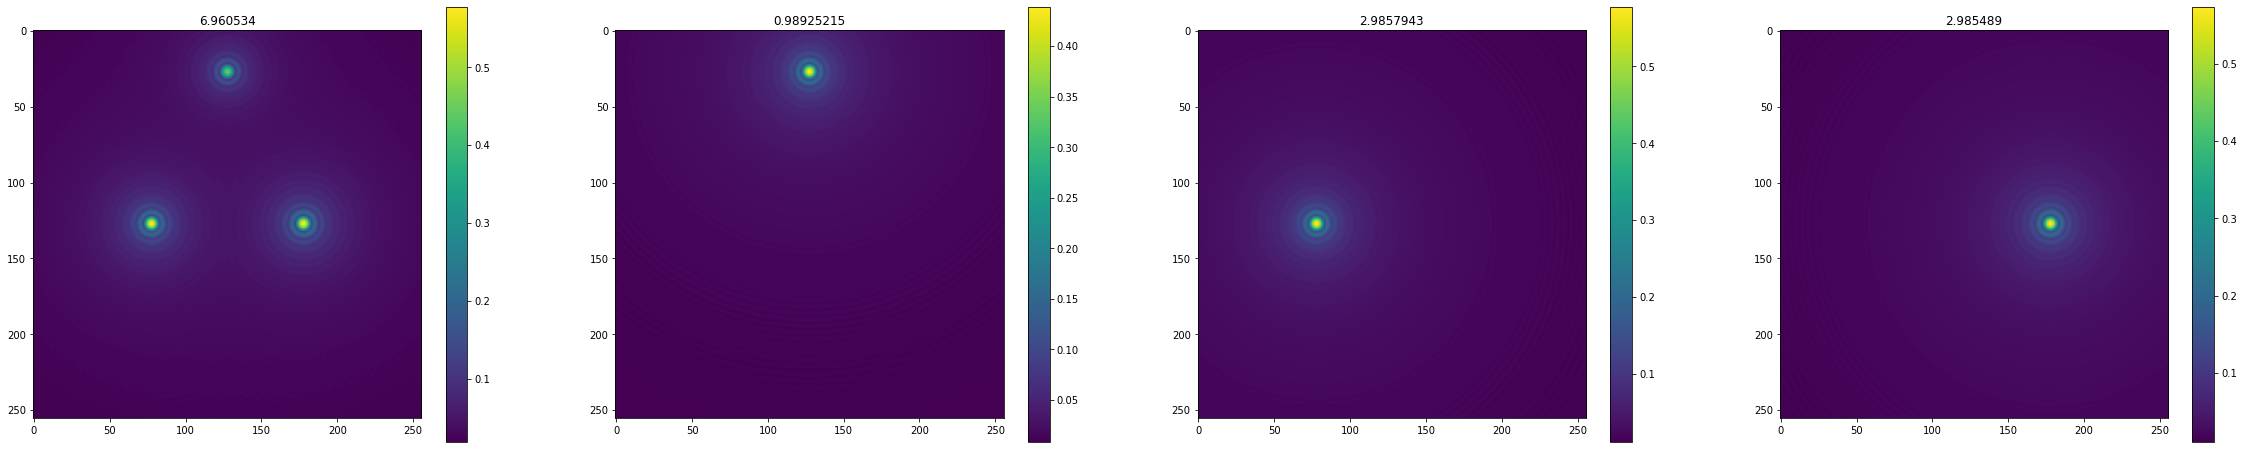

In [15]:
plt.figure(figsize=(40, 8))
plt.subplot(1, 4, 1)
plt.title(image.sum())
plt.imshow(image**0.25)
plt.colorbar()

for i in range(len(psfs)):
    plt.subplot(1, 4, i+2)
    plt.title(psfs[i].sum())
    plt.imshow(psfs[i]**0.25)
    plt.colorbar()
plt.show()

---

# Filter

In [16]:
from base import Filter
filt = Filter()
print(filt.get_throughput(np.array([1e4, 1e5])))

[1. 1.]


---

# Detector

In [17]:
from base import Detector
detector = Detector()

---

# Telescope

In [18]:
# Combined Spectrum for Binary
nwavels = 10
wavels = np.linspace(4e-7, 5e-7, nwavels)
wavelengths = [wavels, wavels]
weights = [np.ones(nwavels), np.linspace(0.5, 1, nwavels)]
combined_spectrum = CombinedSpectrum(wavelengths, weights)

# Binary Source
position = np.zeros(2)
separation = 1e-5
field_angle = 0

flux = 1
flux_ratio = 2

resolved = [False, False]
binary_source = BinarySource(position, mean_flux, separation, field_angle, flux, combined_spectrum, resolved, name="Binary")

# Spectrum for Point Source
point_spectrum = ArraySpectrum(wavelengths[0])
point_position = np.array([0, 1e-5]) # On axis
point_source = PointSource(point_position, flux, point_spectrum, name="Point")

# Combine into Scene
scene = Scene([point_source, binary_source])

# Optical system
layers = [dl.CreateWavefront(256, 1),
          dl.TiltWavefront(),
          dl.CompoundAperture([0.5]),
          dl.NormaliseWavefront(),
          dl.AngularMFT(1e-7, 256)]
osys = Optics(layers)

In [19]:
from base import Telescope
telescope = Telescope(osys, scene)

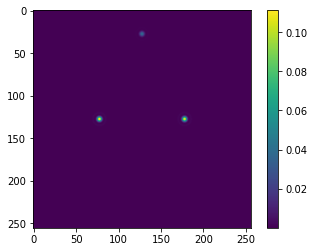

In [20]:
data = telescope.model_scene()
plt.imshow(data)
plt.colorbar()
plt.show()

---

# Gradient Tests

In [21]:
filter_spec = jax.tree_map(lambda _: False, telescope)
filter_spec = eqx.tree_at(lambda telescope: telescope.scene.sources["Binary"].separation, filter_spec, True)

In [22]:
@eqx.filter_jit(fn=eqx.is_inexact_array)
@eqx.filter_value_and_grad(arg=filter_spec)
def loss_fn(telescope, data):
    psf = telescope.model_scene()
    return np.sum(np.square(psf - data))

In [23]:
model = eqx.tree_at(lambda telescope: telescope.scene.sources["Binary"].separation, telescope, 1.1e-5)
loss, grads = loss_fn(model, data)
loss, grads.scene.sources['Binary'].separation

(DeviceArray(0.53792584, dtype=float32),
 DeviceArray(349129.28, dtype=float32, weak_type=True))

In [24]:
import optax
from tqdm.notebook import tqdm

/Users/louis/mambaforge/envs/dlux/lib/python3.10/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


In [25]:
optim = optax.adam(1e-6)
opt_state = optim.init(model)

errors, grads_out, models_out = [], [], []

with tqdm(range(100),desc='Gradient Descent') as t:
    for i in t: 
        # calculate the loss and gradient
        loss, grads = loss_fn(model, data) 
        
        # apply the update
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        
        # save results
        models_out.append(model) 
        errors.append(loss)
        grads_out.append(grads)
        
        t.set_description('Loss %.5f' % (loss)) # update the progress bar

Gradient Descent:   0%|          | 0/100 [00:00<?, ?it/s]

In [26]:
psf_out = model.model_scene()

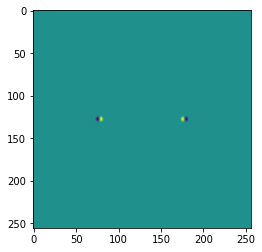

In [27]:
plt.imshow(data - psf_out)

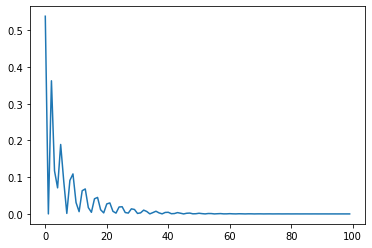

In [28]:
plt.plot(errors)